<a href="https://colab.research.google.com/github/Yale-QCS/hello-quantum-world/blob/main/quantum101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Welcome to ⟨hello|Quantum|world⟩!</h1>

Get ready to discover the new frontier in computing and probe into the quantum world from your fingertips. In this tutorial, we will delve into the fundamental principles of quantum computing.

## What will you learn?
⟨hello|Quantum|world⟩ consists of two sessions:
* session 1: Understanding quantum computing via QuTiP. (30-45 mins)
 * superposition, measurement, interference, entanglement
 * gate commutation relations, circuit simulations
 * Bloch sphere representation, phase kickback
* session 2: Accessing actual quantum hardware via Qiskit. (30-45 mins)
 * Fending off decoherence.
 * Fighting systematic control errors.





---



# Getting Started
Install required packages:

In [1]:
pip install qutip qutip_qip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 9.4 MB/s eta 0:00:00


Set up programming envinroment:

In [2]:
from qutip import about
from qutip import basis, fidelity, Bloch, tensor, rand_dm, rand_ket, mesolve
from qutip import identity, sigmam, sigmax, sigmay, sigmaz
from qutip_qip.operations import gate_sequence_product
from qutip_qip.circuit import QubitCircuit, CircuitSimulator
from qutip_qip.qasm import read_qasm, print_qasm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from qutip.ipynbtools import plot_animation
from qutip.measurement import measure

%matplotlib inline

Verify environment (QuTiP Version: 4.7.1):

In [ ]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.1
Numpy Version:      1.22.4
Scipy Version:      1.10.1
Cython Version:     0.29.34
Matplotlib Version: 3.7.1
Python Version:     3.10.12
Number of CPUs:     2
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/local/lib/python3.10/dist-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `



---



# Session 1 - Fundamentals of quantum programming

### Data types and operators

Qubits are two-level quantum systems. For example, we use energy levels of natural or artificial atoms. The quantum information stored in qubits can be described mathematically by a superposition of basis states, such as |0⟩ and |1⟩.

In [3]:
ket_zero = basis(2,0)
ket_one = basis(2,1)
psi = 0.6*ket_zero + 0.8*ket_one

We can visualize the quantum state on a Bloch sphere:

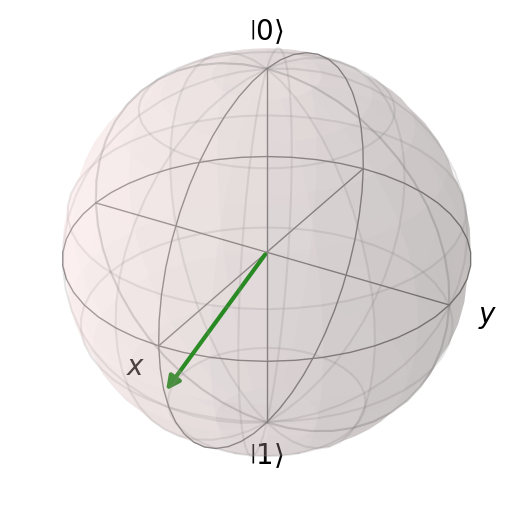

In [ ]:
b = Bloch()
b.add_states(psi)
b.show()

Define common quantum states: |+⟩, |-⟩, |+i⟩, |-i⟩. It's important to note that all quantum states must be normalized, i.e., |𝛹⟩= α|0⟩ + β|1⟩, where |α|^2+|β|^2 = 1.

In [49]:
# Your implementation here
ket_plus = (ket_zero + (1+0j)*ket_one).unit()
ket_minus = rand_ket(2)
ket_plus_i = rand_ket(2)
ket_minus_i = rand_ket(2)

Multiple qubits represent a higher dimensional Hilbert space: |000⟩ = |0⟩⊗|0⟩⊗|0⟩

In [ ]:
ket_zeros = basis([2] * 3, [0] * 3)
assert(ket_zeros == tensor(ket_zero,ket_zero,ket_zero))

What is |+++>?

In [ ]:
# Your implementation here
ket_pluses = rand_ket(8)

QuTiP has some useful built-in quantum gates:

*   Hadamard gate: `snot(), 'SNOT'`
*   Pauli X gate: `x_gate(), 'X'`
*   Pauli X gate: `y_gate(), 'Y'`
*   Pauli X gate: `z_gate(), 'Z'`
*   CNOT gate: `cnot(), 'CNOT'`

You can find more details about built-in operations by importing their associated object in QuTiP:


In [4]:
from qutip_qip.operations import (Gate, snot, x_gate, y_gate, z_gate,
                                  rx, ry, rz, cnot, cphase, swap, iswap,
                                  sqrtnot, toffoli, fredkin,
                                  gate_sequence_product, globalphase)

Applying Hadamard gate twice does nothing, because multiplying two H gate matrices is equivalent to the identity, i.e., HH = I:

In [ ]:
U = gate_sequence_product([snot(), snot()])
U.tidyup()
U == identity(2)

True

Which other gates are their own inverses?

In [ ]:
# Your implementation here




---



### Quantum circuits

Creating an EPR pair using a circuit of two qubits. We can output its associated "assembly instructions", which is a common low-level machine language that can be interpreted by a quantum hardware.

In [5]:
qc = QubitCircuit(2)
qc.add_gate("SNOT", targets=[0])
qc.add_gate("CNOT", targets=[1], controls=[0])
print_qasm(qc)

// QASM 2.0 file generated by QuTiP

OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];

h q[0];
cx q[0],q[1];


In a quantum circuit, does the ordering of applying the gates matter? Whether we can reorder two gates is determined by their commutation relation. For example, because (I⊗X)(X⊗I) = (X⊗I)(I⊗X), the following two quantum circuits are equivalent:

In [12]:
qc1 = QubitCircuit(2)
qc1.add_gate("X", targets=[0])
qc1.add_gate("X", targets=[1])

qc2 = QubitCircuit(2)
qc2.add_gate("X", targets=[1])
qc2.add_gate("X", targets=[0])

(gate_sequence_product(qc1.propagators()) == gate_sequence_product(qc2.propagators()))

True

Can you interchange the ordering of H gate and X gate on the same qubit?

In [15]:
qc1 = QubitCircuit(1)
qc1.add_gate("SNOT", targets=[0])
qc1.add_gate("X", targets=[0])

qc2 = QubitCircuit(1)
qc2.add_gate("X", targets=[0])
qc2.add_gate("SNOT", targets=[0])

(gate_sequence_product(qc1.propagators()) == gate_sequence_product(qc2.propagators()))

False

What about the following two circuits? Are they equivalent? Can you verify mathematically that's true?

In [16]:
qc1 = QubitCircuit(1)
qc1.add_gate("SNOT", targets=[0])
qc1.add_gate("X", targets=[0])

qc2 = QubitCircuit(1)
qc2.add_gate("Z", targets=[0])
qc2.add_gate("SNOT", targets=[0])

(gate_sequence_product(qc1.propagators()) == gate_sequence_product(qc2.propagators()))

True

Circuit simulation and reasoning over code. (Limited to small programs.)

In [35]:
qc = QubitCircuit(2)
qc.add_gate("SNOT", targets=[0])
qc.add_gate("CNOT", targets=[1], controls=[0])
#print_qasm(qc)
print("\n===Simulation Results===\n")
initial_state = tensor(ket_zero, ket_zero)
sim = CircuitSimulator(qc)
print("Initial state:\n" , initial_state)
results = sim.run(state=initial_state)
print("Final state:\n", results.final_states)

// QASM 2.0 file generated by QuTiP

OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];

h q[0];
cx q[0],q[1];

===Simulation Results===

Initial state:
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
Final state:
 [Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]]




---



### Interference and entanglement

In the lecture, we saw how applying a Hadamard gate on the |+⟩=|0⟩+|1⟩ state will cause the state to interfere constructively on |0⟩ and destructively on |1⟩. What if the qubit was entangled with another qubit, will the interference pattern look different? Specifically, what would happen if we apply a Hadamard gate to the first qubit of |00⟩+|11⟩?

In [37]:
qc = QubitCircuit(2, num_cbits=1)
qc.add_gate("SNOT", targets=[0])
qc.add_gate("CNOT", targets=[1], controls=[0])
qc.add_gate("SNOT", targets=[0])
qc.add_measurement("M0", targets=[0], classical_store=0)
print_qasm(qc)

// QASM 2.0 file generated by QuTiP

OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[1];

h q[0];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0]


Does the CNOT gate change the state of the control qubit? Check result from measuring the first qubit, which include the measurement outcome, the remaining state of the second qubit, and their associated probability.

In [46]:
initial = tensor(ket_zero, ket_zero)
results = qc.run_statistics(initial)
for cbit, state, prob in zip(results.cbits, results.final_states, results.probabilities):
    print("Measurement result: {}\nState:\n{}\nwith probability {}\n".format(cbit,state, prob))

Measurement result: [0]
State:
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]
with probability 0.4999999999999998

Measurement result: [1]
State:
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.70710678]
 [-0.70710678]]
with probability 0.4999999999999998



What if we change the initial state?

In [52]:
initial = tensor(ket_zero, ket_plus)
results = qc.run_statistics(initial)
for cbit, state, prob in zip(results.cbits, results.final_states, results.probabilities):
    print("Measurement result: {}\nState:\n{}\nwith probability {}\n".format(cbit, state, prob))

Measurement result: [0]
State:
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]
with probability 0.9999999999999996



Notice that the two qubits stay unentangled. This is because |+> is an eigenstate of X gate with eigenvalue 1, i.e., X|+> = |+>. So the CX gate does not have any effect on the second qubit.

What about |0->?

In [53]:
initial = tensor(ket_zero, ket_minus)
results = qc.run_statistics(initial)
for cbit, state, prob in zip(results.cbits, results.final_states, results.probabilities):
    print("Measurement result: {}\nState:\n{}\nwith probability {}\n".format(cbit, state, prob))

Measurement result: [1]
State:
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.70710678]
 [-0.70710678]]
with probability 0.9999999999999996



Here the two qubits are |-> is an eigenstate of X but with eigenvalue -1. So after the CX gate, the control qubit picks up a phase: |-->.

This phenomenon is called "phase kickback", a technique widely used in quantum algorithms, such as the Bernstein-Vazirani algorithm and the phase estimation algorithm.



---



### Flipping quantum coins

Suppose your quantum physcist friend has promised to send you multiple identical quantum coins, which store some unknown quantum state (in our case we use `rand_ket(2)` to simulate). Can you use the following measurement experiments to determine the state of the coin? Feel free to verify its Bloch sphere coordinates via plotting `Bloch()`.

In [76]:
def one_shot_measure(qc, input, n):
  results = qc.run_statistics(input)
  prob = results.probabilities
  bits = [np.binary_repr(i, width=n) for i in range(2**n)]
  return np.random.choice(bits, 1, p=prob)

def flip_quantum_coins(coins, n, axis='z'):
  qc = QubitCircuit(n, num_cbits=n)
  for i in range(n):
    if axis == 'x':
      qc.add_gate("SNOT", targets=[i])
      qc.add_measurement("M0", targets=[i], classical_store=0)
    elif axis == 'y':
      qc.add_gate("S", targets=[i])
      qc.add_gate("SNOT", targets=[i])
      qc.add_measurement("M0", targets=[i], classical_store=0)
    elif axis == 'z':
      qc.add_measurement("M0", targets=[i], classical_store=0)
    else:
      print("Axis {} not supported.\n".format(axis))
  #print_qasm(qc)
  results = one_shot_measure(qc, coins, n)
  return results

coin = rand_ket(2)
coins = tensor(coin, coin, coin, coin)
x_val = 0
results = flip_quantum_coins(coin, 4, 'z')
# Can you use flip_quantum_coins to estiamte the coin's x, y, z coordinates in the Bloch sphere?

['0100']




---



# Session 2 - Probing quantum hardware

1. Prepare EPR on two (remote) qubits on some topology.
2. Prepare circuit for IBM Q.
3. Set up quantum hardware,
4. run on quantum hardware,
5. interpreting noisy results.
6. In practice, even idle gate is hard

The simplest thing in theory can be hard in practice. Keeping qubits idle... XY4 sequence, then alternating sequence.

# New Section